# Experiment 3aii: Random Isotropic Perturbations at Thought Anchors (KL vs. ε)

This notebook mirrors Experiment 3a's setup but replaces targeted steering with random isotropic perturbations in the residual stream at selected layers.

Protocol:
- Use the same anchor/counterfactual prompt pairs as in 3a (from the annotated dataset).
- At the token just before the anchor, sample random unit directions in hidden space.
- Scale each perturbation by ε times the RMS of the (unperturbed) residual at that token/layer.
- Compute KL divergence over the anchor chunk next-token distributions vs. the unperturbed run.
- Plot KL vs. ε, averaging over random directions (and examples).


In [3]:
import os, json, math, random, gc
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

import sys
sys.path.append(os.path.abspath(os.path.join(os.path.dirname('__file__'), '..')))

from pathlib import Path
# Find repo root by searching upwards for 'generated_data' (fallback: cwd)
repo_root = Path.cwd().resolve().parents[0] if (Path.cwd()).exists() else Path.cwd().resolve()
from utils import load_model_and_vectors, split_solution_into_chunks

# Parameters (keep consistent with 3a where possible)
model_name = 'deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B'
max_examples = 8  # subset for a quick run; increase as needed
selected_layers = [20, 22, 24, 26]  # e.g., [24, 26, 28]; None = use last layer only
epsilons = [0.0, 0.25, 0.5, 1.0, 2.0, 4.0, 8.0, 16.0]  # multiples of RMS
n_directions = 8  # random directions per epsilon
seed = 42
random.seed(seed); torch.manual_seed(seed)

# Resolve device in the same way as other experiments
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'
device

/opt/conda/envs/anchorsteering/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'cuda'

In [4]:
# Load model and tokenizer (no features needed)
model, tokenizer, _ = load_model_and_vectors(model_name=model_name, compute_features=False, device=device)
tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = 'left'
hidden_size = model.config.hidden_size
num_layers = model.config.num_hidden_layers
if selected_layers is None:
    selected_layers = [num_layers - 1]  # last layer default
selected_layers

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


No mean vectors found for deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B. You can save to generated_data/mean_vectors_deepseek-r1-distill-qwen-1.5b.pt.


[20, 22, 24, 26]

In [5]:
# Load annotated dataset produced by Experiment 2
model_tag = model_name.replace('/', '-')
annotated_path = repo_root / 'generated_data' / f'generated_data_annotated_{model_tag}.json'
assert annotated_path.exists(), f'Missing annotated dataset: {annotated_path}'
with open(annotated_path, 'r') as f:
    annotated = json.load(f)
# Filter to examples with an anchor sentence
examples = [ex for ex in annotated if ex.get('thought_anchor_sentence')]
if max_examples is not None:
    examples = examples[:max_examples]
len(examples)

2

In [6]:
def find_anchor_token_span(full_text: str, cot_text: str, anchor_sentence: str):
    """Locate token-span [start, end) of the anchor sentence within full_text.
    First try char-to-token mapping; fallback to sub-token sequence search.
    Returns (start_idx, end_idx, think_start_idx_char).
    """
    think_start = full_text.find('<think>')
    if think_start < 0:
        think_start = 0
    # Char mapping approach
    try:
        offsets = tokenizer.encode_plus(full_text, return_offsets_mapping=True)['offset_mapping']
    except Exception:
        offsets = None
    if offsets:
        anchor_char = cot_text.find(anchor_sentence)
        if anchor_char >= 0:
            cot_in_full = full_text.find(cot_text[:max(1, min(20, len(cot_text)))])
            base_char = cot_in_full if cot_in_full >= 0 else think_start
            start_char = base_char + anchor_char
            end_char = start_char + len(anchor_sentence) - 1
            char_to_tok = {}
            for ti, (s,e) in enumerate(offsets):
                for cp in range(s, e):
                    char_to_tok[cp] = ti
            ts = char_to_tok.get(start_char, None)
            te = char_to_tok.get(end_char, None)
            if ts is not None and te is not None and ts < te:
                return ts, te+1, think_start
    # Fallback: sub-token match
    ids_full = tokenizer(full_text, return_tensors='pt', add_special_tokens=False)['input_ids'][0].tolist()
    ids_anchor = tokenizer(anchor_sentence, return_tensors='pt', add_special_tokens=False)['input_ids'][0].tolist()
    approx_ts = 0
    try:
        prefix = tokenizer(full_text[:think_start], return_tensors='pt', add_special_tokens=False)['input_ids'][0]
        approx_ts = int(prefix.shape[-1])
    except Exception:
        approx_ts = 0
    hay = ids_full[approx_ts:]
    def find_subseq(h, n):
        L, M = len(h), len(n)
        for i in range(max(0, L-M+1)):
            if h[i:i+M] == n:
                return i
        return -1
    pos = find_subseq(hay, ids_anchor)
    if pos >= 0:
        s = approx_ts + pos
        return s, s+len(ids_anchor), think_start
    return None, None, think_start

def build_full_text(ex):
    base = ex.get('raw_response') or ''
    if not base:
        prompt = ex.get('model_input_prompt') or ''
        cot = ex.get('cot') or ''
        base = prompt + cot
    return base

def kl_between_logits(logits_p, logits_q):
    logp = F.log_softmax(logits_p, dim=-1)
    logq = F.log_softmax(logits_q, dim=-1)
    p = logp.exp()
    kl = (p * (logp - logq)).sum(dim=-1)
    return float(kl.mean().item())

def unit_random_direction(dim, device, dtype):
    v = torch.randn(dim, device=device, dtype=torch.float32)
    v = v / (v.norm() + 1e-12)
    return v.to(device=device, dtype=dtype)


In [7]:
import numpy as np

@torch.no_grad()
def _forward_with_logits(input_ids, attention_mask):
    # Forward through the underlying HF model; project to logits if needed
    outputs = model.model(input_ids=input_ids, attention_mask=attention_mask, use_cache=False, output_hidden_states=True, return_dict=True)
    logits = getattr(outputs, 'logits', None)
    if logits is None:
        last_hidden = outputs.last_hidden_state if hasattr(outputs, 'last_hidden_state') else outputs[0]
        head_owner = model if hasattr(model, 'lm_head') else (model.model if hasattr(model.model, 'lm_head') else None)
        if head_owner is None:
            raise AttributeError('Could not find lm_head on model or model.model')
        logits = head_owner.lm_head(last_hidden)
    return logits

@torch.no_grad()
def logits_with_random_perturb_for(prefix_ids: torch.Tensor, attn_mask: torch.Tensor, eps: float, layer_idx: int, dir_vec: torch.Tensor, target_pos: int | None = None):
    """One-step perturbation at the last position of the chosen layer using a random direction.
    Computes RMS and delta in float32, then casts back to original dtype on assignment.
    """
    backbone = getattr(model.model, 'model', model.model)
    target = backbone.layers[layer_idx]
    d = dir_vec.to(torch.float32)
    d = d / (d.norm() + 1e-12)
    def hook(module, inputs, output):
        # Choose which token position to perturb (default: last token)
        pos = -1 if target_pos is None else int(target_pos)
        out = output
        try:
            if isinstance(out, tuple):
                h = out[0].clone()
                rest = out[1:]
            else:
                h = out.clone()
                rest = tuple()
            # Work in float32 for RMS and delta
            h_last_fp32 = h[:, pos:pos+1, :].to(torch.float32)
            # Ensure direction is on same device as hidden
            d_local = d.to(device=h_last_fp32.device, dtype=torch.float32)
            rms = torch.sqrt(torch.mean(h_last_fp32 ** 2) + 1e-20)
            delta_fp32 = (float(eps) * rms) * d_local.view(1, 1, -1)
            new_last = (h_last_fp32 + delta_fp32).to(h.dtype)
            h[:, pos:pos+1, :] = new_last
            return (h,) + rest if isinstance(out, tuple) else h
        except Exception:
            return output
    handle = target.register_forward_hook(hook)
    try:
        logits = _forward_with_logits(prefix_ids, attn_mask)
        return logits[:, -1, :]
    finally:
        handle.remove()

@torch.no_grad()

@torch.no_grad()
def logits_with_random_perturb_full(input_ids: torch.Tensor, attention_mask: torch.Tensor, eps: float, layer_idx: int, dir_vec: torch.Tensor, target_pos: int):
    """Run a full forward pass with a perturbation applied at a specific token position (teacher-forced).
    The perturbation is applied at the given layer and token index within the input.
    """
    backbone = getattr(model.model, 'model', model.model)
    target = backbone.layers[layer_idx]
    d = dir_vec.to(torch.float32)
    d = d / (d.norm() + 1e-12)
    def hook(module, inputs, output):
        out = output
        try:
            if isinstance(out, tuple):
                h = out[0].clone()
                rest = out[1:]
            else:
                h = out.clone()
                rest = tuple()
            pos = int(target_pos)
            if pos < 0 or pos >= h.shape[1]:
                return output
            h_slice_fp32 = h[:, pos:pos+1, :].to(torch.float32)
            d_local = d.to(device=h_slice_fp32.device, dtype=torch.float32)
            rms = torch.sqrt(torch.mean(h_slice_fp32 ** 2) + 1e-20)
            delta_fp32 = (float(eps) * rms) * d_local.view(1, 1, -1)
            new_slice = (h_slice_fp32 + delta_fp32).to(h.dtype)
            h[:, pos:pos+1, :] = new_slice
            return (h,) + rest if isinstance(out, tuple) else h
        except Exception:
            return output
    handle = target.register_forward_hook(hook)
    try:
        return _forward_with_logits(input_ids, attention_mask)
    finally:
        handle.remove()
def kl_from_logits(avg_logits_p, avg_logits_q):
    logp = torch.log_softmax(avg_logits_p, dim=-1)
    logq = torch.log_softmax(avg_logits_q, dim=-1)
    p = torch.exp(logp)
    return torch.sum(p * (logp - logq), dim=-1)

results = {layer: {float(eps): [] for eps in epsilons} for layer in selected_layers}
# Store per-chunk KL curves and their importance for plotting
chunk_curves = {layer: [] for layer in selected_layers}

teacher_forced_mode = True  # compare distributions at same positions
perturb_every_step = False  # set True to perturb each step of the chunk

# Iterate examples and all chunks
for ex_idx, ex in enumerate(examples, start=1):
    question = ex.get('prompt', '')
    cot_text = ex.get('cot') or ''
    try:
        from utils import split_solution_into_chunks
        chunks = split_solution_into_chunks(cot_text)
    except Exception:
        import re
        chunks = [p.strip() for p in re.split(r'(?<=[\.!\?])\s+|\n\n+', cot_text) if p.strip()]
    if not chunks:
        continue
    cf_importance = ex.get('counterfactual_importance_kl', [0.0]*len(chunks))

    for chunk_idx, chunk_text in enumerate(chunks):
        # Build prefix and align spans
        prefix_text = '\n'.join(chunks[:chunk_idx])
        chunk_ids = tokenizer(chunk_text, return_tensors='pt', add_special_tokens=False)['input_ids']
        n_steps = int(chunk_ids.shape[-1])
        prompt_prefix = (
            'Solve the following problem step by step. You MUST put your final answer in \boxed{}.\n\n'
            + f'Problem: {question}\n\n'
            + 'Solution:\n<think>\n'
            + prefix_text
        )
        enc_prefix = tokenizer(prompt_prefix, return_tensors='pt')
        ids_pref = enc_prefix['input_ids'].to(device)
        pad_id = tokenizer.pad_token_id if tokenizer.pad_token_id is not None else (tokenizer.eos_token_id or 0)
        am_pref = (ids_pref != pad_id).long().to(device)
        enc_full = tokenizer(prompt_prefix + chunk_text, return_tensors='pt')
        ids_full = enc_full['input_ids'].to(device)
        am_full = (ids_full != pad_id).long().to(device)
        full_ids = ids_full[0].tolist()
        chunk_seq = tokenizer(chunk_text, return_tensors='pt', add_special_tokens=False)['input_ids'][0].tolist()
        s_idx = -1
        for pos in range(max(0, ids_pref.shape[-1]-4), len(full_ids)-len(chunk_seq)+1):
            if full_ids[pos:pos+len(chunk_seq)] == chunk_seq:
                s_idx = pos
                break
        if s_idx == -1:
            s_idx = int(ids_pref.shape[-1])
        start = max(0, s_idx - 1)
        logits_full = _forward_with_logits(ids_full, am_full)
        seq_len = int(logits_full.shape[1])
        n_eff = max(0, min(n_steps, seq_len - start))
        if n_eff == 0:
            continue
        base_steps = logits_full[:, start:start + n_eff, :]
        base_avg = base_steps.mean(dim=1)

        hidden_size = getattr(model.config, 'hidden_size', None) or getattr(model.config, 'n_embd', None)
        for L in selected_layers:
            fixed_dirs = [unit_random_direction(hidden_size, device=device, dtype=torch.float32) for _ in range(max(1, int(n_directions)))]
            # Compute a KL curve across epsilons for this chunk and layer
            y_curve = []
            if teacher_forced_mode:
                for eps in epsilons:
                    if eps == 0.0:
                        y_curve.append(0.0)
                        continue
                    dir_kls = []
                    for d in fixed_dirs:
                        steered_logits = logits_with_random_perturb_full(ids_full, am_full, float(eps), L, d, start)
                        steered_span = steered_logits[:, start:start + n_eff, :]
                        base_span = logits_full[:, start:start + n_eff, :]
                        kl_t = kl_from_logits(steered_span.reshape(-1, steered_span.shape[-1]), base_span.reshape(-1, base_span.shape[-1]))
                        dir_kls.append(float(kl_t.mean().item()))
                    y_curve.append(sum(dir_kls)/len(dir_kls) if dir_kls else 0.0)
            else:
                for eps in epsilons:
                    if eps == 0.0:
                        y_curve.append(0.0)
                        continue
                    dir_kls = []
                    for d in fixed_dirs:
                        logs = []
                        pf = ids_pref.clone(); amf = am_pref.clone()
                        for k in range(n_steps):
                            if perturb_every_step or k == 0:
                                l = logits_with_random_perturb_for(pf, amf, float(eps), L, d)
                            else:
                                logits_k = _forward_with_logits(pf, amf)
                                l = logits_k[:, -1, :]
                            logs.append(l.detach().to(torch.float32))
                            next_id = torch.argmax(l, dim=-1)
                            pf = torch.cat([pf, next_id.unsqueeze(0)], dim=1)
                            amf = torch.cat([amf, torch.ones_like(next_id).unsqueeze(0)], dim=1)
                        steered_avg = torch.stack(logs, dim=0).mean(dim=0)
                        kl = kl_from_logits(steered_avg, base_avg)
                        dir_kls.append(float(kl.item()))
                    y_curve.append(sum(dir_kls)/len(dir_kls) if dir_kls else 0.0)
            # Save for plotting and aggregate results if desired
            chunk_curves[L].append({
                'example_index': ex_idx-1,
                'chunk_index': chunk_idx,
                'importance': float(cf_importance[chunk_idx]) if chunk_idx < len(cf_importance) else 0.0,
                'ys': y_curve,
            })
            # Also keep the old aggregated results by averaging across chunks (optional)
            for eps, val in zip(epsilons, y_curve):
                results[L][float(eps)].append(float(val))

# Aggregate per-layer averages across examples/chunks
summary = {L: {eps: (sum(vals)/len(vals) if vals else 0.0) for eps, vals in eps_map.items()} for L, eps_map in results.items()}
summary

{20: {0.0: 0.0,
  0.25: 0.00032294276372893995,
  0.5: 0.00033269717317560446,
  1.0: 0.00035683663926370764,
  2.0: 0.0004062797550273978,
  4.0: 0.0006176682553537514,
  8.0: 0.00144879165189037,
  16.0: 0.005617100259532099},
 22: {0.0: 0.0,
  0.25: 0.0003066601677109366,
  0.5: 0.0003199177470220172,
  1.0: 0.00033332709395124215,
  2.0: 0.0004190871411043665,
  4.0: 0.0007037259587694122,
  8.0: 0.002012803745658501,
  16.0: 0.009129193813904472},
 24: {0.0: 0.0,
  0.25: 0.00026035906099106955,
  0.5: 0.0002598202706355116,
  1.0: 0.00029749004170298576,
  2.0: 0.0003897422094545935,
  4.0: 0.0007147604761564213,
  8.0: 0.0024095402787561,
  16.0: 0.014638795800831007},
 26: {0.0: 0.0,
  0.25: 0.00014389153701536682,
  0.5: 0.00015681284054627886,
  1.0: 0.0002010954624932745,
  2.0: 0.000301392257982946,
  4.0: 0.0007379522304172101,
  8.0: 0.002883638214805852,
  16.0: 0.017795987103296364}}

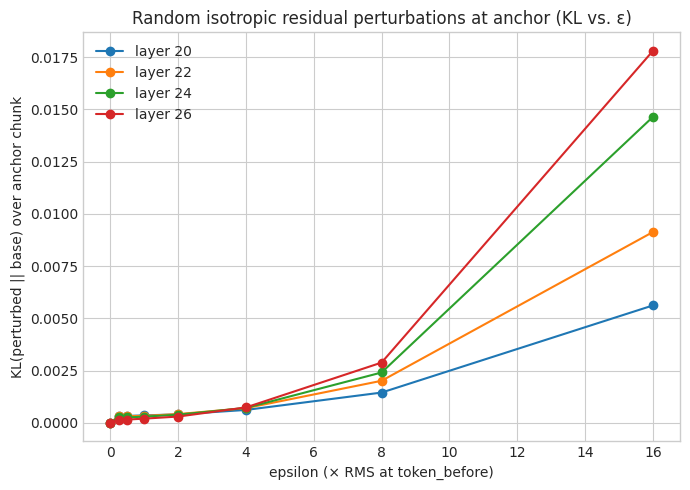

In [8]:
# Plot KL vs. epsilon per selected layer
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(7,5))
for L in selected_layers:
    xs = [float(e) for e in epsilons]
    ys = [summary[L].get(float(e), 0.0) for e in epsilons]
    ax.plot(xs, ys, marker='o', label=f'layer {L}')
ax.set_xlabel('epsilon (× RMS at token_before)')
ax.set_ylabel('KL(perturbed || base) over anchor chunk')
ax.set_title('Random isotropic residual perturbations at anchor (KL vs. ε)')
ax.legend()
plt.tight_layout()
plt.show()

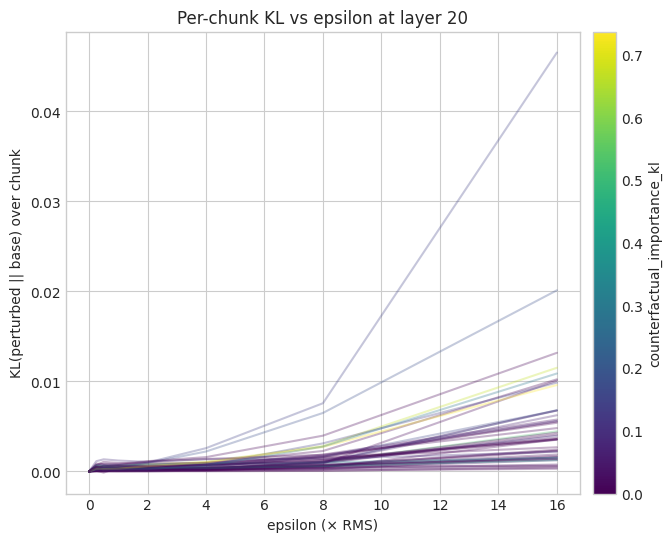

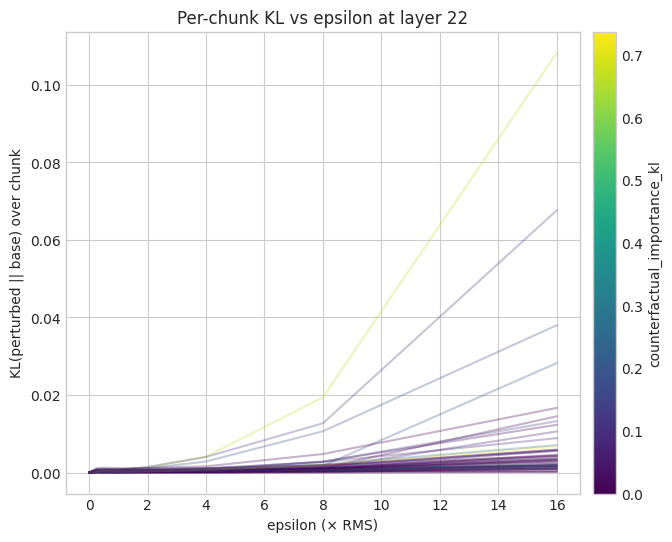

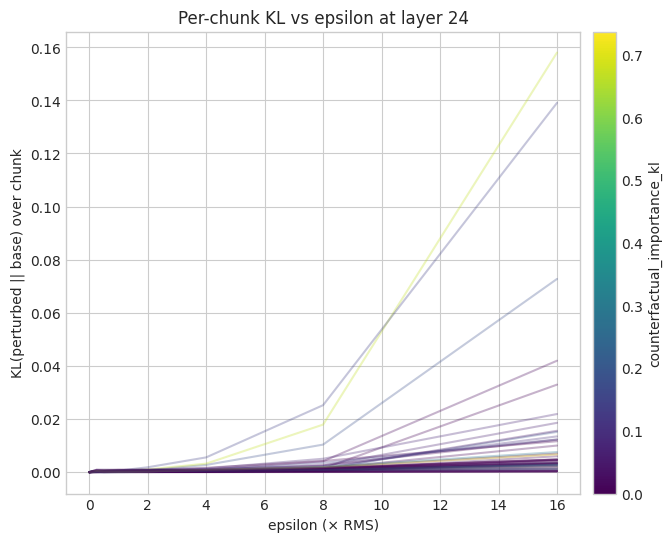

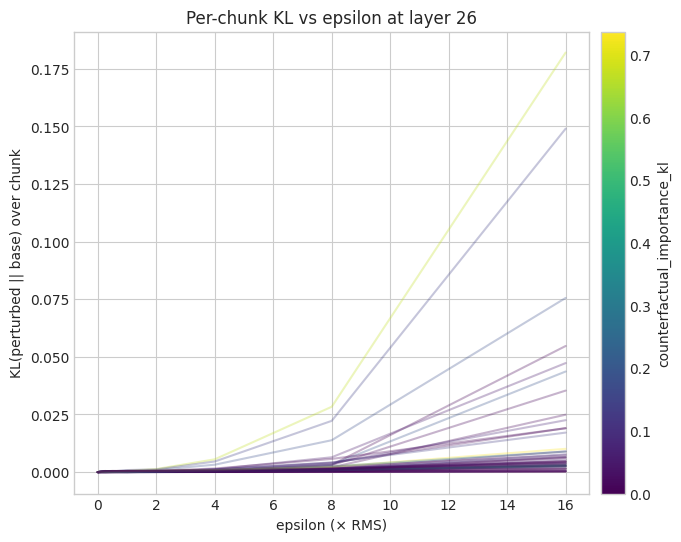

In [9]:
# Plot per-chunk KL vs epsilon, color-coded by counterfactual_importance_kl
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import viridis
from matplotlib.colors import Normalize
plt.style.use('seaborn-v0_8-whitegrid')
for L in selected_layers:
    curves = chunk_curves.get(L, [])
    if not curves:
        continue
    imps = np.array([c['importance'] for c in curves], dtype=float)
    # Normalize importance to [0,1] for colormap
    imp_min, imp_max = float(np.nanmin(imps)), float(np.nanmax(imps) if np.any(np.isfinite(imps)) else 1.0)
    norm = Normalize(vmin=imp_min, vmax=imp_max if imp_max>imp_min else imp_min+1e-6)
    fig, ax = plt.subplots(figsize=(8,6))
    for entry in curves:
        color = viridis(norm(entry['importance']))
        ys = entry['ys']
        xs = [float(e) for e in epsilons]
        ax.plot(xs, ys, color=color, alpha=0.3, linewidth=1.5)
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, pad=0.02)
    cbar.set_label('counterfactual_importance_kl')
    ax.set_xlabel('epsilon (× RMS)')
    ax.set_ylabel('KL(perturbed || base) over chunk')
    ax.set_title(f'Per-chunk KL vs epsilon at layer {L}')
    plt.show()

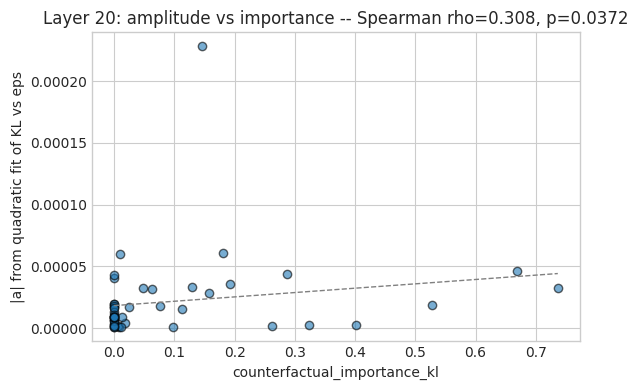

Layer 20: n_points=46, spearman_rho=0.3082220182280188, pval=0.037163017790095884


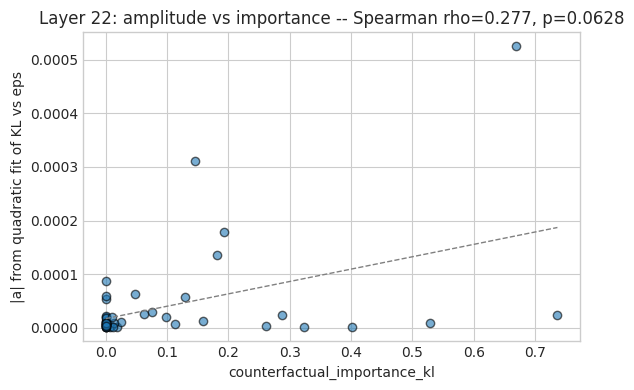

Layer 22: n_points=46, spearman_rho=0.27653075707885855, pval=0.06283348224652606


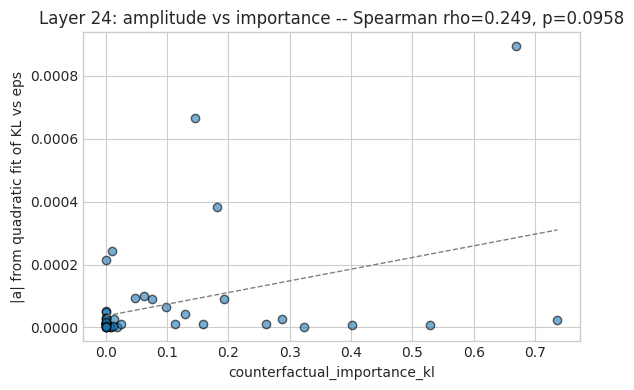

Layer 24: n_points=46, spearman_rho=0.2485640358998057, pval=0.09577223784823326


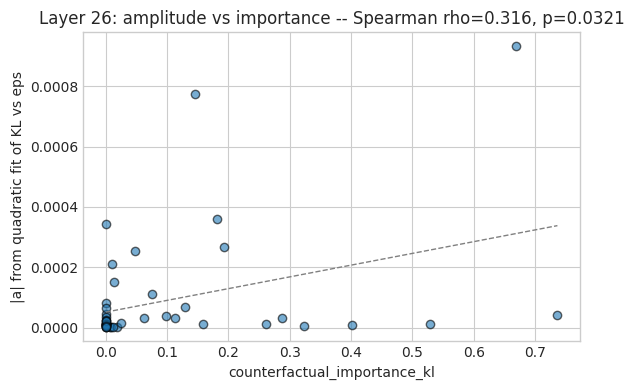

Layer 26: n_points=46, spearman_rho=0.31645521184615116, pval=0.0321420374361553


In [10]:
# Fit each KL curve (y vs eps) to a quadratic and plot amplitude vs counterfactual_importance_kl
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import viridis
# Use SciPy spearman if present; fallback to rank+pearson
try:
    from scipy.stats import spearmanr
    _have_scipy = True
except Exception:
    _have_scipy = False
# We'll treat amplitude as the absolute quadratic coefficient |a| from y(eps)=a*eps^2 + b*eps + c
eps_floats = np.array([float(e) for e in epsilons])
for L in selected_layers:
    curves = chunk_curves.get(L, [])
    if not curves:
        print(f'Layer {L}: no chunk curves found')
        continue
    amplitudes = []  # |a| values
    importances = []
    for c in curves:
        ys = np.array(c.get('ys', []), dtype=float)
        # Align lengths (use min length)
        if ys.size == 0:
            continue
        n = min(len(eps_floats), len(ys))
        x = eps_floats[:n]
        y = ys[:n]
        # Require at least 3 points to fit a quadratic
        if len(x) < 3 or np.all(np.isnan(y)):
            continue
        # Robustly fit degree-2 polynomial
        try:
            coeffs = np.polyfit(x, y, 2)  # [a, b, c]
            a = float(coeffs[0])
            amp = float(np.abs(a))
        except Exception:
            amp = np.nan
        if not np.isnan(amp):
            amplitudes.append(amp)
            importances.append(float(c.get('importance', 0.0)))
    if len(amplitudes) == 0:
        print(f'Layer {L}: no valid quadratic fits')
        continue
    x = np.array(importances)
    y = np.array(amplitudes)
    # Compute Spearman correlation between importance and amplitude
    if _have_scipy:
        try:
            rho, pval = spearmanr(x, y)
        except Exception:
            rho, pval = np.nan, np.nan
    else:
        # fallback: rank + Pearson on ranks
        def _ranks(arr):
            order = np.argsort(arr)
            ranks = np.empty_like(order, dtype=float)
            ranks[order] = np.arange(len(arr), dtype=float)
            return ranks
        rx = _ranks(x)
        ry = _ranks(y)
        if np.nanstd(rx) == 0 or np.nanstd(ry) == 0:
            rho, pval = np.nan, np.nan
        else:
            rho = float(np.corrcoef(rx, ry)[0,1])
            pval = np.nan
    # Plot amplitude vs importance (no colorbar)
    fig, ax = plt.subplots(figsize=(6,4))
    sc = ax.scatter(x, y, edgecolor='black', alpha=0.6)
    ax.set_xlabel('counterfactual_importance_kl')
    ax.set_ylabel('|a| from quadratic fit of KL vs eps')
    title = f'Layer {L}: amplitude vs importance -- Spearman rho={np.nan if rho is None else float(rho):.3f}'
    if not np.isnan(pval):
        title += f', p={float(pval):.3g}'
    ax.set_title(title)
    # Optional linear guide for visualization
    try:
        m, b = np.polyfit(x, y, 1)
        xs = np.linspace(x.min(), x.max(), 100)
        ax.plot(xs, m*xs + b, color='gray', linestyle='--', linewidth=1)
    except Exception:
        pass
    plt.tight_layout()
    plt.show()
    print(f'Layer {L}: n_points={len(x)}, spearman_rho={rho}, pval={pval}')